# Visualize the connectome

In [1]:

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from giskard.plot import adjplot, scattermap
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.plot import networkplot
from matplotlib.patheffects import Normal, Stroke
from pkg.data import (
    load_maggot_graph,
    load_network_palette,
    load_node_palette,
    load_unmatched,
)
from pkg.io import get_environment_variables
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from scipy.cluster import hierarchy
from umap import UMAP

_, _, DISPLAY_FIGS = get_environment_variables()

FILENAME = "show_data"

rng = np.random.default_rng(8888)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


t0 = time.time()
set_theme(font_scale=1.25)

network_palette, NETWORK_KEY = load_network_palette()
network_palette["L"] = network_palette["Left"]
network_palette["R"] = network_palette["Right"]
node_palette, NODE_KEY = load_node_palette()

left_adj, left_nodes = load_unmatched("left")
right_adj, right_nodes = load_unmatched("right")

Environment variables:
   RESAVE_DATA: true
   RERUN_SIMS: true
   DISPLAY_FIGS: False



In [2]:


ase = AdjacencySpectralEmbed(n_components=24, check_lcc=False, concat=True)
left_ase_embedding = ase.fit_transform(left_adj)
right_ase_embedding = ase.fit_transform(right_adj)


umapper = UMAP(
    n_components=2,
    n_neighbors=64,
    min_dist=0.8,
    metric="cosine",
    random_state=rng.integers(np.iinfo(np.int32).max),
)
left_umap_embedding = umapper.fit_transform(left_ase_embedding)
right_umap_embedding = umapper.fit_transform(right_ase_embedding)

In [3]:

networkplot_kws = dict(
    x="x",
    y="y",
    edge_linewidth=0.15,
    edge_alpha=0.2,
    node_hue="hemisphere",
    palette=network_palette,
    edge_hue="source",
    node_size="degree",
    node_sizes=(15, 100),
)


def soft_axis_off(ax, top=False, bottom=False, left=False, right=False):
    ax.spines["top"].set_visible(top)
    ax.spines["bottom"].set_visible(bottom)
    ax.spines["left"].set_visible(left)
    ax.spines["right"].set_visible(right)


fig, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw=dict(wspace=0))

ax = axs[0]
soft_axis_off(ax)

left_nodes["degree"] = left_adj.sum(axis=0) + left_adj.sum(axis=1)
left_nodes["x"] = left_umap_embedding[:, 0]
left_nodes["y"] = left_umap_embedding[:, 1]

networkplot(left_adj, node_data=left_nodes.reset_index(), ax=ax, **networkplot_kws)

ax.set_xlabel("Left", color=network_palette["Left"], fontsize=60)
ax.set_ylabel("")

ax = axs[1]
soft_axis_off(ax)

right_nodes["x"] = right_umap_embedding[:, 0]
right_nodes["y"] = right_umap_embedding[:, 1]
right_nodes["degree"] = right_adj.sum(axis=0) + right_adj.sum(axis=1)

networkplot(right_adj, node_data=right_nodes.reset_index(), ax=ax, **networkplot_kws)

ax.set_xlabel("Right", color=network_palette["Right"], fontsize=60)
ax.set_ylabel("")

fig.set_facecolor("white")

gluefig("2_network_layout", fig)

In [4]:


X = left_ase_embedding


def specsort(X, metric="cosine"):
    Z = hierarchy.linkage(X, method="average", metric=metric)
    Z_ordered = hierarchy.optimal_leaf_ordering(Z, X, metric=metric)
    sorted_indices = hierarchy.leaves_list(Z_ordered)
    return sorted_indices

In [5]:

left_sort_inds = specsort(left_ase_embedding)
right_sort_inds = specsort(right_ase_embedding)

left_sorted_index = np.array(left_nodes.index[left_sort_inds])
right_sorted_index = np.array(right_nodes.index[right_sort_inds])

In [6]:

sorted_index = np.concatenate((left_sorted_index, right_sorted_index))

mg = load_maggot_graph()

mg = mg.node_subgraph(sorted_index)

nodes = mg.nodes
adj = mg.sum.adj

(<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>)

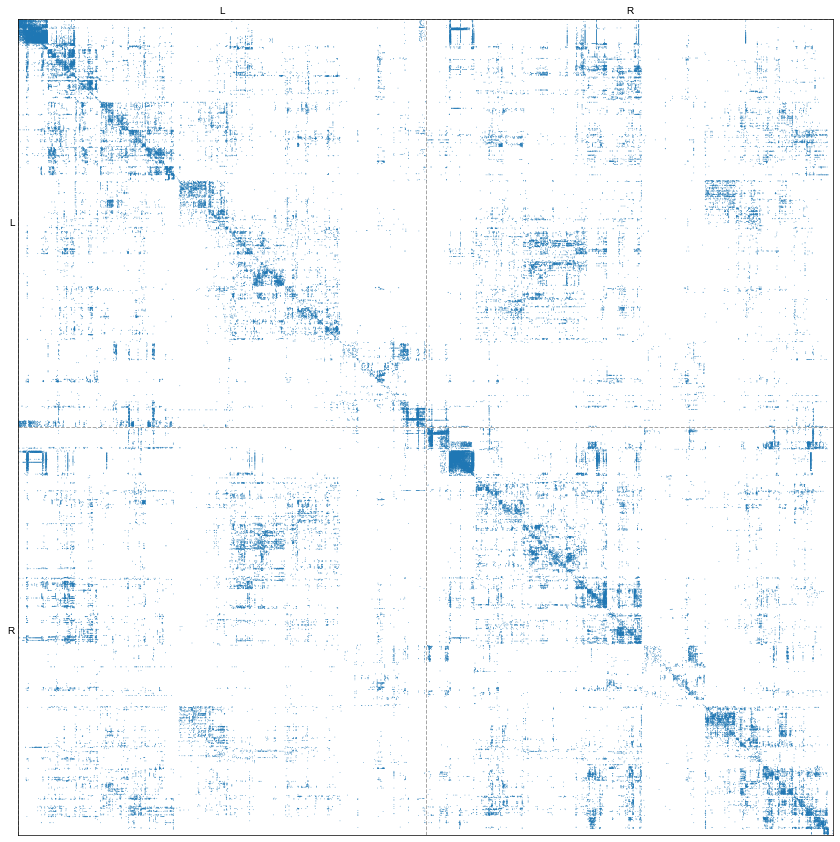

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
adjplot(
    adj,
    meta=nodes,
    sort_class="hemisphere",
    plot_type="scattermap",
    sizes=(0.5, 0.5),
    ax=ax,
)

In [8]:

left_inds = np.arange(len(left_adj))
right_inds = np.arange(len(right_adj)) + len(left_adj)
row_inds, col_inds = np.nonzero(adj)

source_is_left = np.isin(row_inds, left_inds)
target_is_left = np.isin(col_inds, left_inds)

colors = np.full(len(row_inds), "Contra")
colors[source_is_left & target_is_left] = "Left"
colors[~source_is_left & ~target_is_left] = "Right"

In [9]:

fig, ax = plt.subplots(1, 1, figsize=(15, 15))


network_palette["Contra"] = sns.color_palette("Set2")[2]
scattermap(adj, hue=colors, palette=network_palette, ax=ax)
ax.spines.top.set_visible(True)
ax.spines.right.set_visible(True)
fig.set_facecolor("w")

n_left = len(left_adj)
div_kws = dict(color="grey", linewidth=3, linestyle=":")
ax.axvline(n_left - 0.5, **div_kws)
ax.axhline(n_left - 0.5, **div_kws)

ticks = [n_left / 2, n_left + len(right_adj) / 2]
ax.set(xticks=ticks, yticks=ticks)
ax.xaxis.tick_top()
texts = ax.set_xticklabels(["Left", "Right"], fontsize="xx-large")
texts[0].set_color(network_palette["Left"])
texts[1].set_color(network_palette["Right"])
texts = ax.set_yticklabels(["Left", "Right"], fontsize="xx-large")
texts[0].set_color(network_palette["Left"])
texts[1].set_color(network_palette["Right"])
ax.tick_params(axis="both", which="major", pad=10)


def nice_text(x, y, s, color="black"):
    text = ax.text(
        x,
        y,
        s,
        color=color,
        fontsize="x-large",
        transform=ax.transData,
        ha="center",
        va="center",
    )
    text.set_path_effects([Stroke(linewidth=8, foreground="white"), Normal()])


nice_text(n_left / 2, n_left / 2, r"L $\rightarrow$ L")
nice_text(n_left / 2, n_left / 2 + n_left, r"R $\rightarrow$ L")
nice_text(n_left / 2 + n_left, n_left / 2, r"L $\rightarrow$ R")
nice_text(1.5 * n_left, 1.5 * n_left, r"R $\rightarrow$ R")


ax.spines[:].set_color("grey")

gluefig("adjacencies", fig, formats=["png"])

In [10]:


fig, axs = plt.subplots(
    1, 4, figsize=(30, 10), gridspec_kw=dict(wspace=0, width_ratios=[1, 0.3, 1, 1])
)

ax = axs[0]

scattermap(adj, hue=colors, palette=network_palette, ax=ax, sizes=(1, 1))
ax.spines.top.set_visible(True)
ax.spines.right.set_visible(True)

n_left = len(left_adj)
div_kws = dict(color="grey", linewidth=3, linestyle=":")
ax.axvline(n_left - 0.5, **div_kws)
ax.axhline(n_left - 0.5, **div_kws)

ticks = [n_left / 2, n_left + len(right_adj) / 2]
ax.set(xticks=ticks, yticks=ticks)
ax.xaxis.tick_top()
texts = ax.set_xticklabels(["Left", "Right"], fontsize="xx-large")
texts[0].set_color(network_palette["Left"])
texts[1].set_color(network_palette["Right"])
texts = ax.set_yticklabels(["Left", "Right"], fontsize="xx-large")
texts[0].set_color(network_palette["Left"])
texts[1].set_color(network_palette["Right"])
ax.tick_params(axis="both", which="major", pad=10)


def nice_text(x, y, s, color="black"):
    text = ax.text(
        x,
        y,
        s,
        color=color,
        fontsize="x-large",
        transform=ax.transData,
        ha="center",
        va="center",
    )
    text.set_path_effects([Stroke(linewidth=8, foreground="white"), Normal()])


nice_text(n_left / 2, n_left / 2, r"L $\rightarrow$ L")
nice_text(n_left / 2, n_left / 2 + n_left, r"R $\rightarrow$ L")
nice_text(n_left / 2 + n_left, n_left / 2, r"L $\rightarrow$ R")
nice_text(1.5 * n_left, 1.5 * n_left, r"R $\rightarrow$ R")


ax.spines[:].set_color("grey")

ax = axs[1]
ax.axis("off")

ax = axs[2]
soft_axis_off(ax)

left_nodes["degree"] = left_adj.sum(axis=0) + left_adj.sum(axis=1)
left_nodes["x"] = left_umap_embedding[:, 0]
left_nodes["y"] = left_umap_embedding[:, 1]


networkplot_kws = dict(
    x="x",
    y="y",
    edge_linewidth=0.15,
    edge_alpha=0.15,
    node_hue="hemisphere",
    palette=network_palette,
    edge_hue="source",
    node_size="degree",
    node_sizes=(10, 100),
)

networkplot(left_adj, node_data=left_nodes.reset_index(), ax=ax, **networkplot_kws)

ax.set_xlabel(
    r"Left $\rightarrow$ left", color=network_palette["Left"], fontsize="xx-large"
)
ax.set_ylabel("")
ax.axis("square")

ax = axs[3]
soft_axis_off(ax)

right_nodes["x"] = right_umap_embedding[:, 0]
right_nodes["y"] = right_umap_embedding[:, 1]
right_nodes["degree"] = right_adj.sum(axis=0) + right_adj.sum(axis=1)

networkplot(right_adj, node_data=right_nodes.reset_index(), ax=ax, **networkplot_kws)

ax.set_xlabel(
    r"Right $\rightarrow$ right", color=network_palette["Right"], fontsize="xx-large"
)
ax.set_ylabel("")
ax.axis("square")

fig.set_facecolor("white")

fig.text(0.07, 0.97, "A) Adjacency matrix", fontweight="bold", fontsize=40)
fig.text(
    0.4, 0.97, "B) Diagrams for ipsilateral networks", fontweight="bold", fontsize=40
)


gluefig("adj_and_layout", fig)

In [11]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:01:46.460993
Completed at 2022-09-26 09:25:48.950608
